# Keypoint detection

### Libraries and Variables

In [1]:
from torch import nn
from torch.nn import functional as nnf
from torchvision.models import resnet18, ResNet18_Weights
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset
import numpy as np
from torchinfo import summary
import os
import json
import random
from itertools import groupby
from PIL import Image
from torchvision import transforms
import torch
from tqdm import tqdm
from skimage.draw import disk
import pandas as pd
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

home_dir = os.path.expanduser('~')
################################### REMOVE
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
home_dir = '/usr/users/henrich1'
###################################
raw_data_dir = os.path.join(home_dir, 'repos/DaNuMa2024/data/raw_data')
output_data_dir = os.path.join(home_dir, 'repos/DaNuMa2024/data/output_data')

### Overview

This notebook offers keypoint detection as an example of an image-to-image tasks. Compared to many other tasks we worked on, we want to obtain a pixel-wise prediction here. That is, for each pixel we want to output a probability whether a certain keypoint is present there or not. We start by adapting a ResNet to produce dense (pixel-wise) output. Then this modified U-Net-style (https://arxiv.org/abs/1505.04597) ResNet will be applied to a keypoint estimation problem. The data we use is based on publicly available data from a paper by Psota et al. about multi-pig part detection: https://www.mdpi.com/1424-8220/19/4/852


### UNet model

In this exercise, we will take a `ResNet18` network and add a decoder such that the network generates an output tensor having the same spatial extent as the input. This network structure is called U-net. Since a U-net relies on saving the activations from the encoder part (in this case the resnet), it is advised to first thoroughly investigate the structure of the resnet:

In [2]:
# instantiate model
rn18 = resnet18(weights=ResNet18_Weights.DEFAULT)
# look at how the input is processed within the network
summary(rn18, input_size=(1, 3, 224, 384))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 192]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 192]         128
├─ReLU: 1-3                              [1, 64, 112, 192]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 96]           --
├─Sequential: 1-5                        [1, 64, 56, 96]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 96]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 96]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 96]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 96]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 96]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 96]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 96]           --
│

In [3]:
# look at how the modules are named
for name, module in rn18.named_modules():
    print(name)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.relu
layer1.0.conv2
layer1.0.bn2
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.relu
layer1.1.conv2
layer1.1.bn2
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.relu
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.relu
layer2.1.conv2
layer2.1.bn2
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.relu
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample
layer3.0.downsample.0
layer3.0.downsample.1
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.relu
layer3.1.conv2
layer3.1.bn2
layer4
layer4.0
layer4.0.conv1
layer4.0.bn1
layer4.0.relu
layer4.0.conv2
layer4.0.bn2
layer4.0.downsample
layer4.0.downsample.0
layer4.0.downsample.1
layer4.1
layer4.1.conv1
layer4.1.bn1
layer4.1.relu
layer4.1.conv2
layer4.1.bn2
avgpool
fc


1) Once you explored the structure, you can go ahead and start implementing the ``UNet`` module. In the first stage of the UNet, the input is processed by the ResNet to obtain a smaller, but information-rich feature map:
* Loop through all resnet modules until "layer4" and successively apply them.
* Store the original input as well as the features of the resnet after the modules named 'relu', 'layer1', 'layer2', 'layer3'. These will be used for the skip-concatenations later.

2) After the encoder stage, the semantically rich features are hierarchically propagated to the original image size. For this, you need to build a ``DecoderBlock`` that will be instantiated multiple times for decoding:
* The first decoder block takes as input the final output of the encoder (after layer4) and the last stored feature from the encoder (layer3).
* The feature from layer4 needs to be upsampled (``nn.ConvTranspose2d``) by a factor of two since it has half the width and height of the last stored feature (check for yourself with summary!)
* The upsampled layer4 feature should then be concatenated with the layer3 feature and further processed with two convolutions. After these convolutions, the channel size should be the normal channel size of layer3 again. So the feature shape is exactly the same as before but it has been 'enriched' by the information from layer4. *One exception*: After the last decoder block, the enriched feature should not have only three channels but rather 64. Three would not be enough to store all keypoint related information.
* The subsequent decoder block takes the enriched layer3 feature and the next stored feature (layer2) as input, and so on until you arrive at the original image input.

3) After all decoder steps have been performed you will end up with a feature map that has the same size as the image and 64 channels. 
* Process this feature map further with a 1x1 convolution to obtain 5 channels (1 for background and the other 4 for the four keypoints) that can be used to obtain probabilities for the keypoints.

In [4]:
class DecoderBlock(nn.Module):
    """
    A DecoderBlock performs upsampling followed by convolutional layers with batch normalization and ReLU activation.
    
    Args:
        input_channels1 (int): Number of input channels for the up-convolution (ConvTranspose2d).
        input_channels2 (int): Number of input channels from the skip connection to be concatenated.
        output_channels (int): Number of output channels after the convolutions.
    """

    def __init__(self, input_channels1, input_channels2, output_channels):
        super().__init__()
        ######### YOUR CODE HERE:
        # up-convolution
        self.deconv = nn.ConvTranspose2d(input_channels1, int(input_channels1/2), kernel_size=2, stride=2)
        
        # further convolutions
        self.conv1 = nn.Conv2d(int(input_channels1/2) + input_channels2, output_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(output_channels)
        self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(output_channels)

    def forward(self, input1, input2):
        """
        Forward pass of the DecoderBlock.
        
        Args:
            input1 (torch.Tensor): The input tensor to be upsampled.
            input2 (torch.Tensor): The input tensor from the skip connection to be concatenated.

        Returns:
            torch.Tensor: The output tensor after upsampling and convolutional processing.
        """
        ######### YOUR CODE HERE:
        # up-convolution and concatenation with skip connection
        input1_up = self.deconv(input1)
        x = torch.cat([input1_up, input2], dim=1)
        
        # further processing with convolutions
        x = self.conv1(x)
        x = self.bn1(x)
        x = nnf.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = nnf.relu(x)
        return x

class UNet(nn.Module):
    """
    A U-Net model with a ResNet backbone for feature extraction and a decoder for upsampling and keypoint prediction.

    Args:
        resnet (nn.Module): A ResNet model to be used as the encoder.
        resnet_layers (list of str): List of layer names from the ResNet model to be used in the encoder.
        resnet_layers_save (list of str): List of layer names from the ResNet model whose activations are to be saved for skip connections.
        input_channels1 (list of int): List of input channel sizes for each DecoderBlock in the decoder.
        input_channels2 (list of int): List of input channel sizes from skip connections for each DecoderBlock in the decoder.
        output_channels (list of int): List of output channel sizes for each DecoderBlock in the decoder.
        final_layer_channels (int): Number of output channels for the final convolutional layer, i.e. the number of keypoint heatmaps.
    """

    def __init__(self, resnet, resnet_layers=['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4'], 
                 resnet_layers_save=['relu', 'layer1', 'layer2', 'layer3'], 
                 input_channels1=[512, 256, 128, 64, 64], input_channels2=[256, 128, 64, 64, 3], output_channels=[256, 128, 64, 64, 64],
                 final_layer_channels=5):
        super().__init__()
        ######### YOUR CODE HERE:

        # resnet
        self.resnet = resnet
        self.resnet_layers = resnet_layers
        self.resnet_layers_save = resnet_layers_save

        # decoder layers
        self.decoder_layers = nn.ModuleList()
        for i in range(len(input_channels1)):
            self.decoder_layers.append(DecoderBlock(input_channels1[i], input_channels2[i], output_channels[i]))
            
        # final convolution to obtain keypoint heatmaps
        self.post_conv = nn.Conv2d(output_channels[-1], final_layer_channels, 1)

    def forward(self, x):
        """
        Forward pass of the U-Net model.
        
        Args:
            x (torch.Tensor): The input tensor, typically an image.
        
        Returns:
            torch.Tensor: The output tensor, typically containing keypoint heatmaps.
        """
        ######### YOUR CODE HERE:
        # save activations of initial input and specified resnet layers
        activations = []
        activations.append(x)

        for layer in self.resnet_layers:
            x = getattr(self.resnet, layer)(x)
            if layer in ['relu', 'layer1', 'layer2', 'layer3']:
                activations.append(x)

        # decoder
        decoder_activations = []
        for i, decoder_layer in enumerate(self.decoder_layers):
            x = decoder_layer(x, activations[-i-1])
            decoder_activations += [x]

        x = self.post_conv(x)

        return x


Pass dummy tensors (e.g. torch.randn) to the network to see if everything works correctly:

In [5]:
######### YOUR CODE HERE:
# instantiate model
dummy_inp = torch.randn(1, 3, 224, 384) * 100
rn18 = resnet18(weights=ResNet18_Weights.DEFAULT)
model = UNet(rn18)

# dummy forward pass
output = model(dummy_inp)
print(output.shape)

torch.Size([1, 5, 224, 384])


For a trained model, we can identify which class (keypoints and background) is predicted to be most likely for a given pixel by calculating the argmax over all channels. The ``plot_pred_and_gt`` function defined here takes as arguments the model output and a ground truth keypoint map and plots the predicted and ground truth class at every pixel position. There is also a dummy ground truth keypoint map defined in the cell. The ground truth has the same width and height as the prediction but only one channel with integers representing the class at a certain image position (keypoints or background).

* Plot the model output you obtained using the dummy input together with the dummy ground truth keypoints. How do you expect the prediction to look?
* ``nnf.cross_entropy`` can be used for image-to-image tasks by applying it per-pixel. Calculate it with the output and dummy ground truth keypoints. What value would you expect? And why is the value you observe maybe a bit different?

######### YOUR ANSWER HERE
* You will see the predictions for the different keypoint being scattered randomly across the image. You might notice that the overall predictions have a slight bias towards a certain keypoint (one color more frequent than others). This is because the weights and biases of the final prediction layer are randomly initialized and might favor a certain keypoint (e.g. bigger bias value than for other keypoints)
* For a randomly initialized model you would expect the predicted probability $p$ for each class to be roughly 20\% since there are 5 classes in total. Since the cross entropy loss for a single pixel boils down to taking the negative log of the predicted probability for the ground truth class, we would expect: $loss = -log(p) = -log(0.2) = 1.609$ \
Once again, through randomly initialized biases, this will vary a little bit. If you manually set all the weights and biases to zero, you'd get exactly that number.

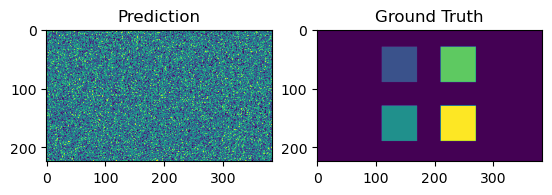

loss: 1.503249168395996


In [6]:
def plot_pred_and_gt(a_pred: torch.Tensor, a_gt: torch.Tensor) -> None:
    """
    This function plots the prediction and the ground truth tensors. The prediction tensor has 3 channels, one for each class.
    The pixels with the highest value over all channels is plotted in the first subplot. The second subplot shows the ground truth.
    """
    _, ax = plt.subplots(1, 2)
    # The argmax(0) returns the highest value for each pixel over the 3 channels.
    # The result is a tensor of shape (H, W) with H height and W width 
    # where each value represents the channel index with the highest value.
    ax[0].imshow(a_pred.argmax(0))
    ax[1].imshow(a_gt)
    ax[0].set_title('Prediction')
    ax[1].set_title('Ground Truth')
    plt.show()
    
# dummy ground truth keypoint locations
a_gt = torch.zeros(224, 384, dtype=torch.int64)
a_gt[30:90, 110:170] = 1
a_gt[130:190, 110:170] = 2
a_gt[30:90, 210:270] = 3
a_gt[130:190, 210:270] = 4


######### YOUR CODE HERE:
plot_pred_and_gt(torch.squeeze(output), a_gt)
print(f'loss: {nnf.cross_entropy(output.float(), a_gt[None, ...])}')

In the following, we created multiple dummy predictions that match the ground truth a little bit better. Looking at the plots, how do you think the cross entropy loss will be for these examples? If you want, you can verify your intuition using the ``nnf.cross_entropy`` function.

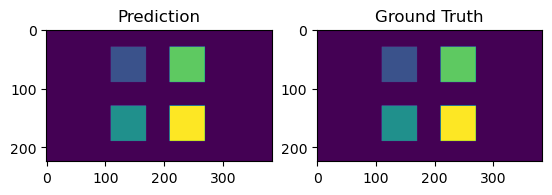

loss: 0.0


In [7]:
# Creates example tensors for the predictions and the ground truth (gt).
prediction = 100
a_pred = -prediction * torch.ones(5, 224, 384)
a_pred[0, ...] = prediction
a_pred[0, 30:90, 110:170] = -prediction
a_pred[0, 130:190, 110:170] = -prediction
a_pred[0, 30:90, 210:270] = -prediction
a_pred[0, 130:190, 210:270] = -prediction
a_pred[1, 30:90, 110:170] = prediction
a_pred[2, 130:190, 110:170] = prediction
a_pred[3, 30:90, 210:270] = prediction
a_pred[4, 130:190, 210:270] = prediction

plot_pred_and_gt(a_pred, a_gt)

######### YOUR CODE HERE:
print(f'loss: {nnf.cross_entropy(a_pred[None, ...], a_gt[None, ...])}')

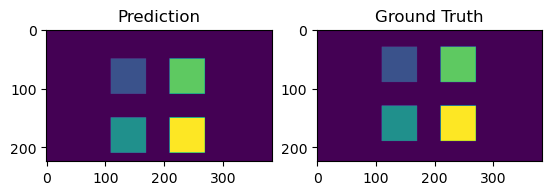

loss: 0.6558673977851868


In [8]:
# Creates example tensors for the predictions and the ground truth (gt).
prediction = 1
a_pred = -prediction * torch.ones(5, 224, 384)
a_pred[0, ...] = prediction
a_pred[0, 50:110, 110:170] = -prediction
a_pred[0, 150:210, 110:170] = -prediction
a_pred[0, 50:110, 210:270] = -prediction
a_pred[0, 150:210, 210:270] = -prediction
a_pred[1, 50:110, 110:170] = prediction
a_pred[2, 150:210, 110:170] = prediction
a_pred[3, 50:110, 210:270] = prediction
a_pred[4, 150:210, 210:270] = prediction

plot_pred_and_gt(a_pred, a_gt)

######### YOUR CODE HERE:
print(f'loss: {nnf.cross_entropy(a_pred[None, ...], a_gt[None, ...])}')

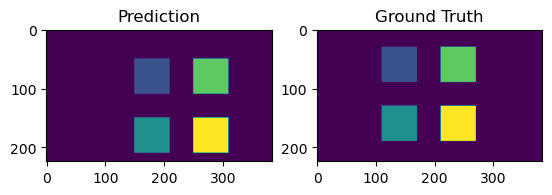

loss: 0.9534865617752075


In [9]:
# Creates example tensors for the predictions and the ground truth (gt).
prediction = 1
a_pred = -prediction * torch.ones(5, 224, 384)
a_pred[0, ...] = prediction
a_pred[0, 50:110, 150:210] = -prediction
a_pred[0, 150:210, 150:210] = -prediction
a_pred[0, 50:110, 250:310] = -prediction
a_pred[0, 150:210, 250:310] = -prediction
a_pred[1, 50:110, 150:210] = prediction
a_pred[2, 150:210, 150:210] = prediction
a_pred[3, 50:110, 250:310] = prediction
a_pred[4, 150:210, 250:310] = prediction

plot_pred_and_gt(a_pred, a_gt)

######### YOUR CODE HERE:
print(f'loss: {nnf.cross_entropy(a_pred[None, ...], a_gt[None, ...])}')

### Data

The below code loads the ``annotations.json`` file and exlores its contents. Since the number of pigs and keypoints per image is variable, the annotation format (standard COCO keypoints annotation format) is a little bit more complex. ``annotations.json`` has multiple entries that contain information regarding the images and keypoints. The information can be linked since annotations are associated with an image id that they belong to. The following code explores the annotations object and performs some preprocessing steps needed to obtain the ``KeypointsDataset`` for model training. You do not need to write any code yourself here and it is also not essential to understand all the code. The code is still commented in case you want to understand what is going on.

In [10]:
# load annotations
images_dir = os.path.join(raw_data_dir, '6_keypoint_detection/images')
pig_kp = json.load(open(os.path.join(raw_data_dir, '6_keypoint_detection/annotations.json')))

In [11]:
############### explore keys of pig_kp dictionary
# only the first three keys are of importance for the task at hand
print('keys of pig_kp object:', pig_kp.keys())

############### explore images entry of pig_kp
print(f'\nsructure of "images" entry of json dict: {pig_kp["images"][0]}')
print(f'number of images: {len(pig_kp["images"])}')
# the important entries for the task at hand are 'file_name', 'id', 'width', 'height'

############### explore annotations entry of pig_kp
print(f'\nsructure of "annotations" entry of json dict: {pig_kp["annotations"][0]}') # important entries are 'file_name', 'id', 'width', 'height'
print(f'number of annotated pigs: {len(pig_kp["annotations"])}')
# each annotated pig is associated with an image through the 'image_id' entry
# it also comes with a category_id, which is always 1 in this case since we only consider pigs
# Most importantly, the 'keypoints' entry contains the four keypoints of the pig. 
# The standard encoding is used, i.e. [x1, y1, v1, x2, y2, v2, ...] where vi is the visibility of the ith keypoint (2: visible, 1: occluded, 0: not visible, but 1 is not used in this dataset).
# The order of they keypoints can be found in the 'categories' entry of pig_kp

############### explore categories entry of pig_kp
print(f'\nsructure of "categories" entry of json dict: {pig_kp["categories"]}') # important entries are 'file_name', 'id', 'width', 'height'

keys of pig_kp object: dict_keys(['images', 'annotations', 'categories'])

sructure of "images" entry of json dict: {'id': 1, 'file_name': '000000001.jpg', 'width': 384, 'height': 224, 'date_captured': '', 'license': 0, 'coco_url': '', 'flickr_url': ''}
number of images: 3420

sructure of "annotations" entry of json dict: {'id': 1, 'image_id': 1, 'category_id': 1, 'keypoints': [148.475, 148.52962962962962, 2, 150.725, 164.86296296296297, 2, 138.6239990234375, 158.58919270833334, 2, 103.3739990234375, 166.36697048611111, 2], 'bbox': [], 'area': 0, 'iscrowd': 0, 'segmentation': [], 'num_keypoints': 4}
number of annotated pigs: 37178

sructure of "categories" entry of json dict: [{'id': 1, 'name': 'pig', 'keypoints': ['left_ear', 'right_ear', 'neck', 'hip'], 'skeleton': []}]


In [12]:
########### creation of helper objects for later use

# filter out empty annotations (some images do not have annotated keypoints)
anns = pig_kp['annotations']
anns = [a for a in anns if len([v for v in a['keypoints'][2::3] if v==2]) > 0]

# create annotations by image_id and annotation id
anns = sorted(anns, key=lambda x:x['image_id'])

# dictionary with image_id as key and list of corresponding annotation ids as value
anns_by_image = {k: [a['id'] for a in v] for k,v in groupby(anns, lambda x: x['image_id'])}

# dictionary with annotation id as key and corresponding annotation information as value
anns_by_id = {a['id']: a for a in anns}

# dictionary with image id as key and corresponding image information as value
images_by_id = {img['id']: img for img in pig_kp['images']}

In [13]:
def get_samples(anns_by_image, anns_by_id, images_by_id, images_dir, img_ids):
    """
    Generate labeled samples for keypoint detection.

    This function processes images and their corresponding keypoint annotations to create a list of samples. 
    Each sample consists of an image and a label tensor, where the label tensor contains integer values 
    where different integer values represents the presence of different keypoints.

    Args:
        anns_by_image (dict): A dictionary mapping image IDs to lists of annotation IDs associated with that image.
        anns_by_id (dict): A dictionary mapping annotation IDs to annotation data, which includes keypoints information.
        images_by_id (dict): A dictionary mapping image IDs to image metadata, including file name, width, and height.
        images_dir (str): The directory where the images are stored.
        img_ids (set): A set of image IDs that should be processed. Images not in this set will be skipped.

    Returns:
        list: A list of tuples, where each tuple contains:
            - img (PIL.Image.Image): The loaded image.
            - labels (PIL.Image.Image): A label tensor image with the same dimensions as the input image. 
              The tensor contains integer values where each keypoint type is represented 
              by a unique integer value (1, 2, 3, ...). The value is 0 where no keypoints are present.
    
    Notes:
        - The function assumes that the `keypoints` field in each annotation is a list where each keypoint is 
          represented by three values: [x, y, v], where `x` and `y` are coordinates and `v` is the visibility flag.
        - Keypoints with a visibility flag `v` equal to 2 are used to label the corresponding locations in the label tensor.
        - The label tensor is filled using small disks centered at the keypoint locations.
    """
    
    samples = []
    for img_id, ann_ids in anns_by_image.items():
        # skip images that are not in the specified img_ids
        if not img_id in img_ids:
            continue
        
        # load image
        filename = os.path.join(images_dir, images_by_id[img_id]['file_name'])
        img = Image.open(filename)
        
        # get width and height of image
        img_w, img_h = images_by_id[img_id]['width'], images_by_id[img_id]['height']

        # create labels tensor that has same width and height as image and fill it wihth zeros initially
        labels = np.zeros((img_h, img_w), 'uint8')    
        
        # get keypoints that are associated with the image. Fill the labels tensor with the respective integer values (1 for first keypoint, 2 for second, ...)
        for i, ann_id in enumerate(ann_ids):
            ann = anns_by_id[ann_id]
            kp = np.array(ann['keypoints']).astype('float32')
            x = kp[0::3]
            y = kp[1::3]
            v = kp[2::3]
            
            for j in range(4):
                if v[j] == 2:
                    rr, cc = disk((y[j], x[j]), 3, shape=(img_h, img_w))
                    labels[rr, cc] = j+1   
                    
        # add image and labels to samples list as a tuple
        labels = Image.fromarray(labels.astype('int8'))
        samples += [(img, labels)]
    return samples


class KeypointsDataset(Dataset):
    def __init__(self, samples):
        # directly store all samples in working memory (This is different from the previous exercises, where we loaded the samples on-the-fly)
        self.samples = samples
        self.img_transform = transforms.Normalize(mean=torch.tensor([0.485, 0.456, 0.406]), # standard normalization for models pretrained on ImageNet
                                        std=torch.tensor([0.229, 0.224, 0.225])
                                        )
        
    def transform(self, img, labels):
        # Convert to tensor and normalize image
        img = transforms.ToTensor()(img)
        labels = transforms.ToTensor()(labels)
        img = self.img_transform(img)
        return img, labels.squeeze()
    
    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, i):
        sample = self.samples[i]
        img, labels = sample
        img, labels = self.transform(img, labels)
        return img, labels
    

In [14]:
# set seed for reproducibility
random.seed(1)

# get img ids for training and validation
all_img_ids = list(images_by_id.keys())

# randomly shuffle img ids and divide them into training and validation img ids
random.shuffle(all_img_ids)
train_inds = all_img_ids[:int(0.9*len(all_img_ids))]
val_inds = all_img_ids[int(0.9*len(all_img_ids)):]

# get corresponding samples for training and validation
samples_train = get_samples(anns_by_image, anns_by_id, images_by_id, images_dir, train_inds)
samples_val = get_samples(anns_by_image, anns_by_id, images_by_id, images_dir, val_inds)

# create dataset and dataloaders with extracted samples
trainset = KeypointsDataset(samples_train)
valset = KeypointsDataset(samples_val)
trainloader = DataLoader(trainset, batch_size=16, shuffle=True)
valloader = DataLoader(valset, batch_size=16, shuffle=False)

print(f'length of validation set: {len(trainset)}')
print(f'length of validation set: {len(valset)}')

length of validation set: 3034
length of validation set: 339


Let's visualize some examples from the keypoints dataset. The label tensor from the dataset has the same shape as the image but only one channel with integers representing the different classes (keypoints and background). The keypoints were enlarged to a small circle (see image) around the keypoint positions from the annotation. 
* Why is that important for training?

######### YOUR ANSWER HERE \
If only one pixel was labeled as the target keypoint, the task would be impossible to train. The pixels right next to the keypoint are not distinguishable but would have to receive a completely different prediction then. Therefore, we extended the keypoints to a larger area that shares semantic structure in the image.

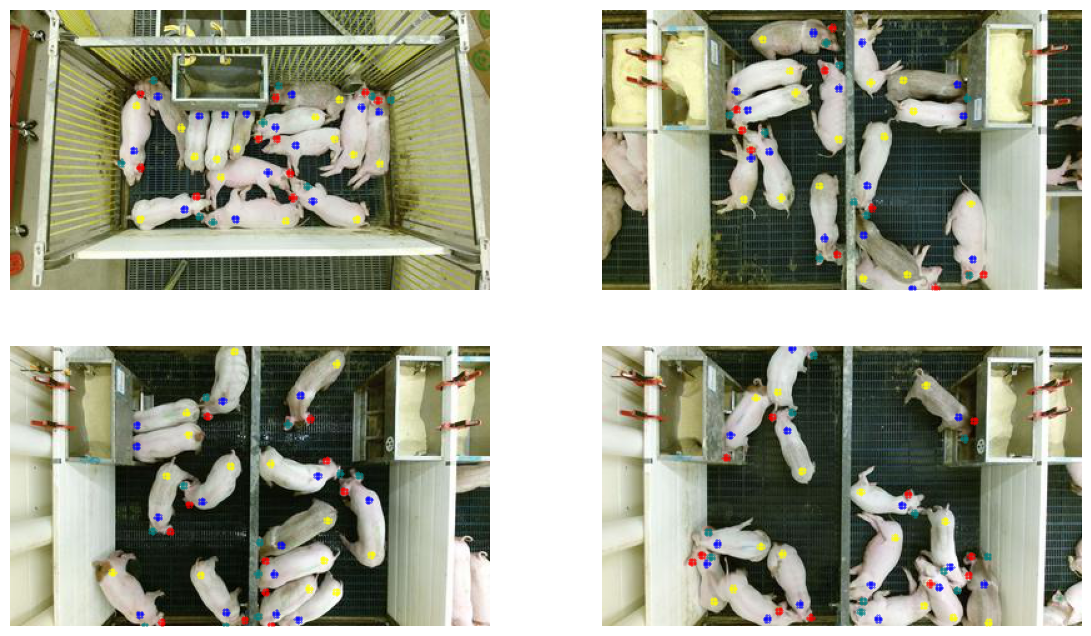

In [15]:
# visualize some samples from KeypointsDataset
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
for i, ax in enumerate(axes.flatten()):
    img, labels = trainset[i]
    img = img * torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    img = img + torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    ax.imshow(img.permute([1, 2, 0]))
    
    # plot keypoints (places where the labels tensor is not zero in the color of the respective keypoint)
    colors = ['red', 'teal', 'blue', 'yellow']
    for j in range(1, 5):
        y, x = torch.where(labels == j)
        ax.scatter(x.numpy(), y.numpy(), c=colors[j-1], s=0.1)  # Plot keypoints
    ax.axis('off')

### training loop

Training the model can, once again, be done using almost exactly the same functions as in the previous exercises! That's why the code is already provided. You can directly start training. Do not forget to monitor the training loss and look for potential issues there!

In [16]:
def train_one_epoch(model, trainloader, optimizer, device):
    model.train()
    total_loss = 0
    for x_batch, y_batch, in trainloader:
        x_batch = x_batch.float().to(device)
        y_batch = y_batch.long().to(device)
        y_pred = model(x_batch)

        optimizer.zero_grad()
        loss = nnf.cross_entropy(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(trainloader)

def validate(model, valloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in valloader:
            x_batch = x_batch.float().to(device)
            y_batch = y_batch.long().to(device)
            y_pred = model(x_batch)
            
            loss = nnf.cross_entropy(y_pred, y_batch)
            total_loss += loss.item()
    return total_loss / len(valloader)

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"The model is running on {device}.")

# training parameters
epochs = 3
lr = 0.001
print_interval = 1

# save best model state dict
save_dir_state_dict = os.path.join(output_data_dir, '6_keypoint_detection')
os.makedirs(save_dir_state_dict, exist_ok=True)
save_path_state_dict = os.path.join(save_dir_state_dict, 'best.pth')
save_path_metrics = os.path.join(save_dir_state_dict, 'metrics.pkl')

# instantiate model and optimizer
rn18 = resnet18(weights=ResNet18_Weights.DEFAULT)
model = UNet(rn18, final_layer_channels=5).cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# training loop
train_losses = []
val_losses = []
min_val_loss = float('inf')

for epoch in tqdm(range(epochs)):
    train_loss = train_one_epoch(model, trainloader, optimizer, device)
    train_losses.append(train_loss)

    val_loss = validate(model, valloader, device)
    val_losses.append(val_loss)
    
    if val_loss < min_val_loss:
        torch.save(model.state_dict(), save_path_state_dict)
        min_val_loss = val_loss
    
    if epoch % print_interval == 0:
        print(f'Epoch {epoch} - train loss: {train_loss:.3f} - val loss: {val_loss:.3f} - lr: {optimizer.param_groups[0]["lr"]}')
        
    metrics = pd.DataFrame({
        'train_loss': train_losses,
        'val_loss': val_losses,
        'lr': optimizer.param_groups[0]['lr']
    })
    metrics.to_pickle(save_path_metrics)

The model is running on cuda.


 33%|███▎      | 1/3 [01:04<02:08, 64.30s/it]

Epoch 0 - train loss: 0.220 - val loss: 0.062 - lr: 0.001


 67%|██████▋   | 2/3 [01:44<00:50, 50.19s/it]

Epoch 1 - train loss: 0.046 - val loss: 0.041 - lr: 0.001


100%|██████████| 3/3 [02:24<00:00, 48.07s/it]

Epoch 2 - train loss: 0.035 - val loss: 0.035 - lr: 0.001


### results

plot the loss curves.

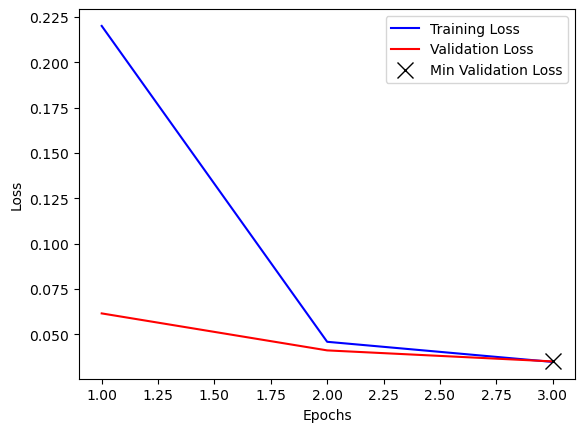

In [18]:
results = pd.read_pickle(save_path_metrics)

####################### plot losses
plt.plot(np.linspace(1, epochs, epochs), results['train_loss'], c='blue', label='Training Loss')
plt.plot(np.linspace(1, epochs, epochs), results['val_loss'], c='red', label='Validation Loss')

# Mark the minimum validation loss
index = np.argmin(results['val_loss'])
plt.plot(index+1, results['val_loss'][index], 'kx', label='Min Validation Loss', markersize=12)

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We now have a model that is able to predict keypoint probabilities. However, right now we get entire areas with high keypoint probabilities since this is what we trained the model to predict:

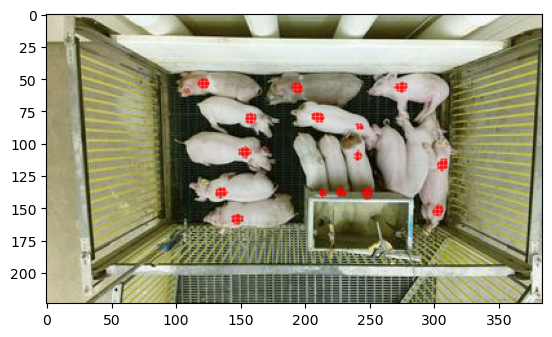

In [19]:
# visualize keypoints
model = UNet(rn18, final_layer_channels=5).cuda()
model.load_state_dict(torch.load(save_path_state_dict))
model.eval()  

img, _ = valset[0]
with torch.no_grad():
    logits = model(img.unsqueeze(0).cuda())

# plot image
img = img * torch.tensor([0.229, 0.224, 0.225])[:, None, None]
img = img + torch.tensor([0.485, 0.456, 0.406])[:, None, None]
plt.imshow(img.permute(1, 2, 0))
# overlay predictions for one keypoint channel
logits = logits.squeeze().cpu()
probabilities = torch.sigmoid(logits)
x, y = torch.where(probabilities[3] > 0.5)
plt.scatter(y, x, s=0.1, c='red')
plt.show()

We need to postprocess these predictions to obtain actual keypoints (i.e. singular xy coordinates) which could then be used for other downstream analyses. Your task is to write a ``get_keypoints`` function that converts keypoint heatmaps into singular keypoints. You can take the following hints as guidance, but feel free to come up with your own idea.

* It takes as input the predicted keypoint probabilities of shape ``5x224x384`` and outputs a map of shape ``224x384`` that contains zeros almost everywhere except for the singular keypoint positions. At these positions there should be integers corresponding to the respective keypoint. 
* Keypoints should fulfil two properties: (1) They are the argmax across all 5 channels and (2) There are no xy positions with higher probabilities nearby, i.e. they are a local maximum within the same channel.
* To determine (2) you can use ``nnf.max_pool2d`` and compare the pooled probabilities with the unpooled probabilities.
* The function argument 'min_distance' represents the minimum distance between two local maxima. Think about the relationship between 'min_distance' and the kernel_size you need to use with ``nnf.max_pool2d``.

In [22]:
def get_keypoints(probabilities, min_distance=4):
    """
    Identify keypoints from a probability map.

    This function processes a probability tensor to extract keypoints. 
    A keypoint is defined as a point that fulfils two criteria: 
    (1) is a local maximum in its channel and (2) must have the 
    highest probability in the respective location across all channels.

    Args:
        probabilities (pytorch tensor): A 3D PyTorch tensor of shape [channels, width, height] representing 
                                        probability maps for each keypoint category.
        min_distance (int, optional): The minimum distance (in pixels) between two maxima detections. 
                                      This determines 'how local' local maxima are.
                                      Default is 4 pixels.

    Returns:
        torch.Tensor: A 2D tensor of the same width and height as the input probabilities, where each 
                      pixel value represents a detected keypoint category (1-4). Pixels with no detected 
                      keypoints are assigned a value of 0.

    """
    ######### YOUR CODE HERE:
    
    # 1) calculate argmax of probabilities
    argmaxs = torch.argmax(probabilities, 0)
    # 2) calculate local maxima of probabilities
    max_filtered=nnf.max_pool2d(probabilities, kernel_size=2*min_distance+1, stride=1, padding=min_distance)
    maximas = torch.eq(max_filtered, probabilities)
    
    # 3) obtain keypoints for all keypoint categories (1-4) by checking whether they fulfil the two conditions
    keypoints = torch.zeros_like(argmaxs)
    for i in [1, 2, 3, 4]:
        mask_keypoints = (argmaxs == i) & maximas[i]
        keypoints[mask_keypoints] = i
    
    # # dummy return
    # dummy_keypoints =  torch.randint(0, 5, (224, 384))
    # dummy_keypoints[torch.rand((224, 384)) > 0.01] = 0
    # keypoints = dummy_keypoints
    return keypoints

Once the ``get_keypoints`` function is finished, you can directly plot the results here.

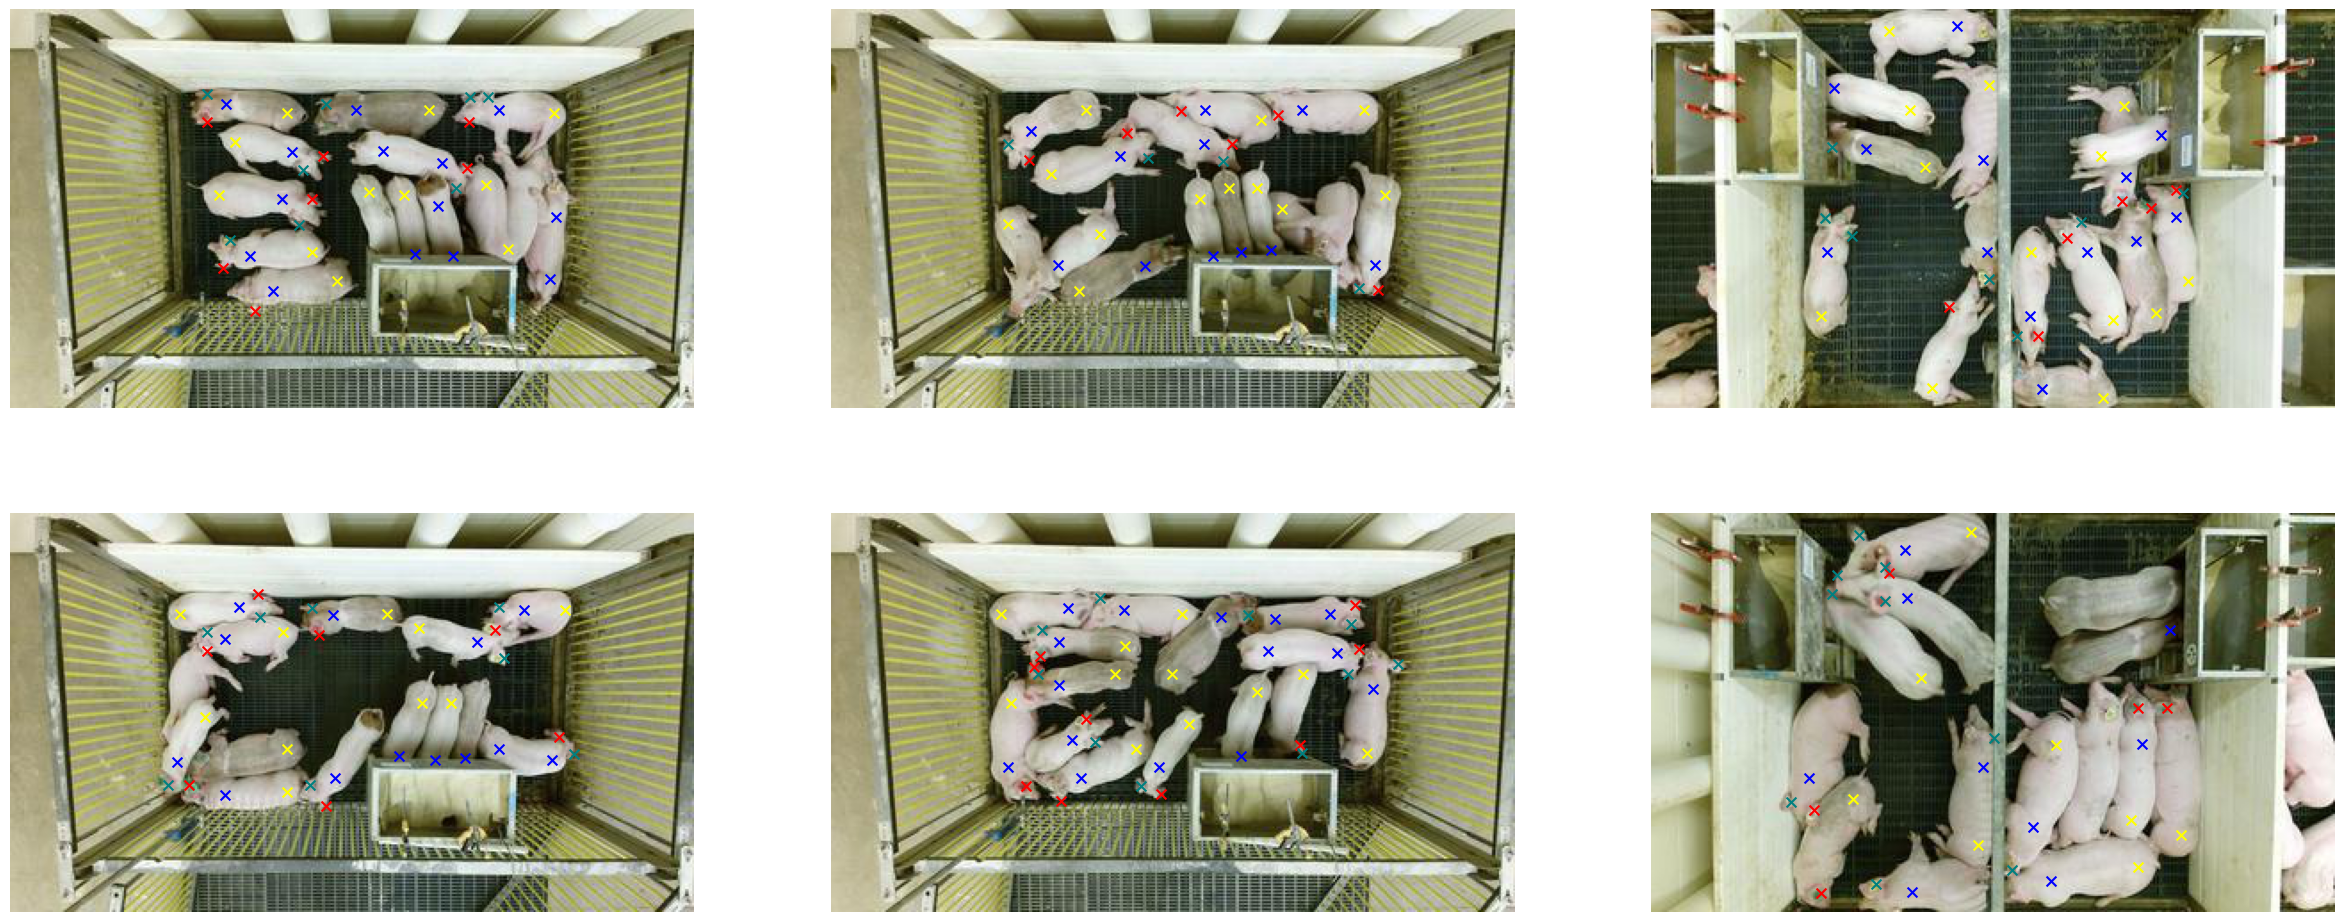

In [23]:
# visualize keypoints
model = UNet(rn18, final_layer_channels=5).cuda()
model.load_state_dict(torch.load(save_path_state_dict))
model.eval()  

fig, axes = plt.subplots(2, 3, figsize=(30, 12))
for i, ax in enumerate(axes.flatten()):
    # get predictions
    img, _ = valset[i]
    with torch.no_grad():
        logits = model(img.unsqueeze(0).cuda())
    
    # calculate probabilities with predictions
    logits = logits.squeeze().cpu()
    probabilities = torch.sigmoid(logits) # could be left out without changing the result, but it is more intuitive to work with probabilities than with logits
    
    # get keypoints
    keypoints = get_keypoints(probabilities)

    # plot image together with keypoints
    img = img * torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    img = img + torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    ax.imshow(img.permute([1, 2, 0]))
    
    colors = ['red', 'teal', 'blue', 'yellow']
    for j in range(1, 5):
        y, x = torch.where(keypoints == j)
        ax.scatter(x.cpu().numpy(), y.cpu().numpy(), c=colors[j-1], s=50, marker='x')  # Plot keypoints

    ax.axis('off')

### Bonus

* Try out different decoder sizes (e.g. channel sizes or number of convolution layers). Does it have an influence on the prediction performance?
* You can also add residual connections in the decoding steps! In fact, the 'Res-Unet' is a popular modern architecture.